In [2]:
import os
import glob
import numpy as np
import scipy as sp
import scipy.stats
import xarray as xr
import pickle as pkl

import mne
import cmlreaders as cml
import cluster_helper.cluster
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib notebook
%matplotlib inline

from constants import FR2_valid_subjects
from utils import compute_ROC_AUC, get_eeg_sys, split_ROIs
from plot_utils import plot_heatmap_contrast, plot_auc_null, plot_ROC

### search inverse regularization param

In [18]:
def search_regularization_hyperparam(sys='egi'):
    
    import warnings
    warnings.filterwarnings('ignore')
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import auc, roc_curve, roc_auc_score
    
    from constants import non_peripheral_egi, non_peripheral_biosemi
    from utils import special_concat, load_feature, resample_enc_events
    
    # use the 24th session to search for good inverse regularization param
    # separately for egi and biosemi sessions
    
    # candidate Cs
    Cs = np.logspace(np.log10(1e-7),np.log10(1e0), num = 10)
    
    if sys == 'egi':
        subjects_all = FR2_valid_subjects[:53]
    
    elif sys == 'biosemi':
        subjects_all = FR2_valid_subjects[53:]
    
    def get_enc_features():
        # 24th session from all participants + leave one subject out
        
        power_all = []
        for subject in subjects_all:
            x = load_feature(subject, task_phase='enc', 
                             exclude_peripheral_channels=True, stack_feature=True)
            
            if 23 not in np.unique(x.events.values['session']): continue
            x = x.sel(events=x.events.values['session']==23)
            power_all.append(x)
        
        power_all = special_concat(power_all)
        return power_all
    
    def divide_folds(subjects, nfold):
        n = int(np.floor(len(subjects) / nfold))
        folds = []
        for i in range(0, len(subjects), n):
            folds.append(subjects[i:i+n])
        return np.array(folds)
    
    def leave_one_subject_out(train_features, test_features, C):
        
        probas = np.empty(len(test_features)) # however many events in data
        labels = np.empty(len(test_features))
        probas.fill(np.nan)
        labels.fill(np.nan)
        
        folds = divide_folds(np.unique(train_features.events.values['subject']),
                             len(np.unique(train_features.events.values['subject']))) # LOSO

        for fold in folds:

            train = np.array([False if s in fold else True for s in train_features.events.values['subject']])
            test = np.array([True if s in fold else False for s in test_features.events.values['subject']])

            train_data = train_features.sel(events=train).copy()
            test_data = test_features.sel(events=test).copy()

            X = train_data.values
            y = train_data.events.values['recalled']

            lr = LogisticRegression(C=C, class_weight='balanced', fit_intercept=False)
            lr = lr.fit(X, y)

            probas[test] = lr.predict_proba(test_data)[:, 1]
            labels[test] = test_data.events.values['recalled']

        return (probas, labels)
    
    train_features = get_enc_features()
    test_features = train_features.copy()
    # train_features = resample_enc_events(train_features)
    
    aucs = {}
    for i, C in enumerate(Cs):
        print(C)
        y_hat, y = leave_one_subject_out(train_features=train_features, 
                                         test_features=test_features,
                                         C=C)
        auc = roc_auc_score(y, y_hat)
        aucs[i] = {'C':C, 'auc':auc}
        
    return aucs

In [19]:
egi_aucs = search_regularization_hyperparam(sys='egi')
biosemi_aucs = search_regularization_hyperparam(sys='biosemi')

1e-07
5.994842503189409e-07
3.5938136638046257e-06
2.1544346900318867e-05
0.0001291549665014884
0.000774263682681127
0.004641588833612782
0.02782559402207126
0.1668100537200059
1.0
1e-07
5.994842503189409e-07
3.5938136638046257e-06
2.1544346900318867e-05
0.0001291549665014884
0.000774263682681127
0.004641588833612782
0.02782559402207126
0.1668100537200059
1.0


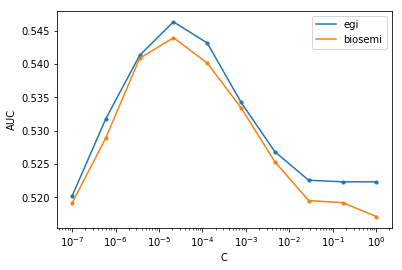

In [11]:
# egi_aucs = {0: {'C': 1e-07, 'auc': 0.5201943444088355},
#  1: {'C': 5.994842503189409e-07, 'auc': 0.5318124160195579},
#  2: {'C': 3.5938136638046257e-06, 'auc': 0.5413067466485945},
#  3: {'C': 2.1544346900318867e-05, 'auc': 0.5463217114742924},
#  4: {'C': 0.0001291549665014884, 'auc': 0.5431472451639308},
#  5: {'C': 0.000774263682681127, 'auc': 0.5342592883588994},
#  6: {'C': 0.004641588833612782, 'auc': 0.5268505781829881},
#  7: {'C': 0.02782559402207126, 'auc': 0.5225795478954558},
#  8: {'C': 0.1668100537200059, 'auc': 0.5223529064675786},
#  9: {'C': 1.0, 'auc': 0.5223500726103174}}
# biosemi_aucs = {0: {'C': 1e-07, 'auc': 0.5191535013165349},
#  1: {'C': 5.994842503189409e-07, 'auc': 0.5289418406644184},
#  2: {'C': 3.5938136638046257e-06, 'auc': 0.5408563310335633},
#  3: {'C': 2.1544346900318867e-05, 'auc': 0.5439449615644496},
#  4: {'C': 0.0001291549665014884, 'auc': 0.5401446724014467},
#  5: {'C': 0.000774263682681127, 'auc': 0.5334293212092932},
#  6: {'C': 0.004641588833612782, 'auc': 0.5253455210034552},
#  7: {'C': 0.02782559402207126, 'auc': 0.519534687945347},
#  8: {'C': 0.1668100537200059, 'auc': 0.5192329756923298},
#  9: {'C': 1.0, 'auc': 0.5171439800464398}}

fig, ax = plt.subplots()
ax.plot(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [egi_aucs[i]['auc'] for i in range(10)], 
         color='C0', label='egi')
ax.scatter(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [egi_aucs[i]['auc'] for i in range(10)], 
         color='C0', s=10)
ax.plot(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [biosemi_aucs[i]['auc'] for i in range(10)], 
         color='C1', label='biosemi')
ax.scatter(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [biosemi_aucs[i]['auc'] for i in range(10)], 
         color='C1', s=10)
ax.set_xscale('log')
ax.set_xlabel('C')
ax.set_ylabel('AUC')
ax.legend()

In [17]:
# fig.savefig('figures_final/hyperparam_resample.pdf')

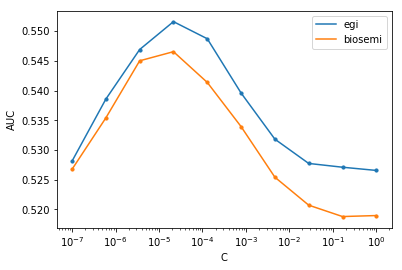

In [25]:
# egi_aucs = {0: {'C': 1e-07, 'auc': 0.5281370374578627},
#  1: {'C': 5.994842503189409e-07, 'auc': 0.5385841171657165},
#  2: {'C': 3.5938136638046257e-06, 'auc': 0.5469380194677489},
#  3: {'C': 2.1544346900318867e-05, 'auc': 0.5516369174330392},
#  4: {'C': 0.0001291549665014884, 'auc': 0.5487541011465885},
#  5: {'C': 0.000774263682681127, 'auc': 0.539612655138016},
#  6: {'C': 0.004641588833612782, 'auc': 0.5318346750058176},
#  7: {'C': 0.02782559402207126, 'auc': 0.5277471336182948},
#  8: {'C': 0.1668100537200059, 'auc': 0.5271094038128408},
#  9: {'C': 1.0, 'auc': 0.5265685892395977}}
# biosemi_aucs = {0: {'C': 1e-07, 'auc': 0.5267631570176315},
#  1: {'C': 5.994842503189409e-07, 'auc': 0.5354193242291934},
#  2: {'C': 3.5938136638046257e-06, 'auc': 0.5450376300753762},
#  3: {'C': 2.1544346900318867e-05, 'auc': 0.5465757590907576},
#  4: {'C': 0.0001291549665014884, 'auc': 0.5413969840389699},
#  5: {'C': 0.000774263682681127, 'auc': 0.5339524885895249},
#  6: {'C': 0.004641588833612782, 'auc': 0.525427596129276},
#  7: {'C': 0.02782559402207126, 'auc': 0.5207190770821908},
#  8: {'C': 0.1668100537200059, 'auc': 0.5187999634379996},
#  9: {'C': 1.0, 'auc': 0.5189673583146736}}

fig, ax = plt.subplots()
ax.plot(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [egi_aucs[i]['auc'] for i in range(10)], 
         color='C0', label='egi')
ax.scatter(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [egi_aucs[i]['auc'] for i in range(10)], 
         color='C0', s=10)
ax.plot(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [biosemi_aucs[i]['auc'] for i in range(10)], 
         color='C1', label='biosemi')
ax.scatter(np.logspace(np.log10(1e-7),np.log10(1e0), num = 10), 
         [biosemi_aucs[i]['auc'] for i in range(10)], 
         color='C1', s=10)
ax.set_xscale('log')
ax.set_xlabel('C')
ax.set_ylabel('AUC')
ax.legend()

In [26]:
# fig.savefig('figures_final/hyperparam.pdf')

In [79]:
# best param
np.logspace(np.log10(1e-7),np.log10(1e0), num = 10)[3]

2.1544346900318867e-05

### individual classifier

In [3]:
def FR2_individual_classifier(subject):
    
    # global flags
    train_phase = 'enc'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'

    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, leave_one_session_out_forward_model

    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                         train_label=train_label, 
                                                                         test_features=test_features, 
                                                                         test_label=test_label,
                                                                         C=best_C)
    # compute average weights and average activation values
    avgW = xr.DataArray(weights.mean(0), dims=('features'), coords={'features':test_features.features})
    avgW = avgW.unstack('features')
    avgA = xr.DataArray(activations.mean(0), dims=('features'), coords={'features':test_features.features})
    avgA = avgA.unstack('features')
    
    auc = roc_auc_score(y, y_hat)
    
    subject_loso_result = {}
    subject_loso_result['auc'] = auc
    subject_loso_result['y'] = y
    subject_loso_result['yhat'] = y_hat
    subject_loso_result['events'] = test_features.events.values
    subject_loso_result['avgW'] = avgW
    subject_loso_result['avgA'] = avgA
    
    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    outputf = 'scratch/mtpower/%s/%s_%s_%s_clsf_result.pkl' % (subject, subject, train_phase, test_phase)
    # pkl.dump(subject_loso_result, open(outputf, 'wb'))
    
    return auc

def FR2_individual_classifier_nullauc(subject):
    
    # global flags
    train_phase = 'ret'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'
    n_tests = 100
    
    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, \
                      leave_one_session_out_forward_model, shuffle_labels
    
    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    # save a copy of original events
    original_events = train_features.events.values.copy()
    
    # perform n_tests many of permutation tests
    aucs_null = np.zeros(n_tests)
    for i in range(len(aucs_null)):

        shuffled_events = shuffle_labels(original_events.copy(), train_label)
        train_features.coords['events'] = shuffled_events

        y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                             train_label=train_label, 
                                                                             test_features=test_features, 
                                                                             test_label=test_label,
                                                                             C=best_C)
        aucs_null[i] = roc_auc_score(y, y_hat)
    
    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    outputf = 'scratch/mtpower/%s/%s_%s_%s_null_aucs.npy' % (subject, subject, train_phase, test_phase)
    # np.save(outputf, aucs_null)

def test_clsf_significance(trainphase, testphase):
    
    def binomial_test(pvals, alpha=0.05):
        count = (pvals < alpha).sum()
        group_p = sp.stats.binom_test(count, len(pvals), 0.05, alternative='greater')
        return group_p
    
    subjects = FR2_valid_subjects
    print('Evaluating FR2 classifier performance for %d subjects...' % (len(subjects)))
    print('    Train phase: %s    Test phase: %s' % (trainphase, testphase))
    
    true_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(trainphase, testphase))
    print('    Mean AUC:', '%.2f'%np.mean(true_aucs), '  +-SE:', sp.stats.sem(true_aucs))
    
    null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'% (subject, subject, trainphase, testphase))
                          for subject in subjects])
    
    pvals = np.array([ (null_aucs[i]>true_aucs[i]).sum()/float(len(null_aucs)) for i in range(len(true_aucs))])
    all_alpha = [0.01, 0.05]
    counts = []
    
    for alpha in all_alpha:
        count = (pvals < alpha).sum()
        counts.append(count)
    
    # remove overlaps 
    # - those who are significant at 0.001 are subtracted from 0.01 and 0.05
    # - those who are significant at 0.01 are subtracted from 0.05
    counts[1] = counts[1]-counts[0]
    
    for i, alpha in enumerate(all_alpha):
        print('    alpha=%.03f: \t %0.2f significant' % (alpha, counts[i]))
    
    print('    p<0.05: ', len(subjects[pvals<0.05])) # subjects[pvals<0.05])
    
    group_p = binomial_test(pvals)
    print('    group binomial test:  p=%.11f, %s' % (group_p, 'significant' if group_p<0.05 else'non significant'))
    group_t, group_p = scipy.stats.ttest_rel(true_aucs, null_aucs.mean(1))
    print('    group t-test: t=%f, p=%f, %s' % (group_t, group_p, 'significant' if group_p<0.05 else'non significant'))
    
    return (subjects[pvals<0.05], subjects[pvals>=0.05])

In [17]:
test_clsf_significance('enc', 'enc')

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.60   +-SE: 0.003678861857653041
    alpha=0.010: 	 88.00 significant
    alpha=0.050: 	 0.00 significant
    p<0.05:  88
    group binomial test:  p=0.00000000000, significant
    group t-test: t=27.540251, p=0.000000, significant


(array(['LTP093', 'LTP106', 'LTP115', 'LTP117', 'LTP123', 'LTP133',
        'LTP138', 'LTP207', 'LTP210', 'LTP228', 'LTP229', 'LTP236',
        'LTP246', 'LTP249', 'LTP250', 'LTP251', 'LTP258', 'LTP259',
        'LTP265', 'LTP269', 'LTP273', 'LTP278', 'LTP279', 'LTP280',
        'LTP283', 'LTP285', 'LTP287', 'LTP293', 'LTP296', 'LTP297',
        'LTP299', 'LTP301', 'LTP302', 'LTP303', 'LTP304', 'LTP305',
        'LTP306', 'LTP307', 'LTP310', 'LTP311', 'LTP312', 'LTP316',
        'LTP317', 'LTP318', 'LTP321', 'LTP322', 'LTP323', 'LTP324',
        'LTP325', 'LTP326', 'LTP327', 'LTP328', 'LTP329', 'LTP331',
        'LTP334', 'LTP336', 'LTP339', 'LTP341', 'LTP342', 'LTP343',
        'LTP344', 'LTP346', 'LTP347', 'LTP348', 'LTP349', 'LTP354',
        'LTP355', 'LTP357', 'LTP360', 'LTP361', 'LTP362', 'LTP364',
        'LTP365', 'LTP366', 'LTP367', 'LTP371', 'LTP372', 'LTP373',
        'LTP374', 'LTP376', 'LTP377', 'LTP385', 'LTP386', 'LTP387',
        'LTP389', 'LTP390', 'LTP391', 'LTP393'],

In [15]:
test_clsf_significance('retci', 'retci')

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.59   +-SE: 0.006709766173937947
    alpha=0.010: 	 54.00 significant
    alpha=0.050: 	 10.00 significant
    p<0.05:  64
    group binomial test:  p=0.00000000000, significant
    group t-test: t=13.574973, p=0.000000, significant


(array(['LTP106', 'LTP115', 'LTP117', 'LTP123', 'LTP133', 'LTP138',
        'LTP207', 'LTP210', 'LTP229', 'LTP251', 'LTP258', 'LTP259',
        'LTP273', 'LTP278', 'LTP279', 'LTP280', 'LTP285', 'LTP287',
        'LTP296', 'LTP297', 'LTP301', 'LTP304', 'LTP306', 'LTP307',
        'LTP310', 'LTP312', 'LTP316', 'LTP317', 'LTP318', 'LTP321',
        'LTP322', 'LTP323', 'LTP325', 'LTP326', 'LTP329', 'LTP334',
        'LTP336', 'LTP339', 'LTP341', 'LTP342', 'LTP343', 'LTP346',
        'LTP347', 'LTP348', 'LTP349', 'LTP354', 'LTP357', 'LTP361',
        'LTP362', 'LTP364', 'LTP365', 'LTP366', 'LTP367', 'LTP371',
        'LTP372', 'LTP373', 'LTP376', 'LTP377', 'LTP385', 'LTP386',
        'LTP387', 'LTP389', 'LTP390', 'LTP393'], dtype='<U6'),
 array(['LTP093', 'LTP228', 'LTP236', 'LTP246', 'LTP249', 'LTP250',
        'LTP265', 'LTP269', 'LTP283', 'LTP293', 'LTP299', 'LTP302',
        'LTP303', 'LTP305', 'LTP311', 'LTP324', 'LTP327', 'LTP328',
        'LTP331', 'LTP344', 'LTP355', 'LTP360', 'LTP3

In [113]:
subjects = FR2_valid_subjects
njobs = len(subjects)
cpj = 1
with cluster_helper.cluster.cluster_view(scheduler='sge', queue='RAM.q', 
                                         num_jobs=njobs, cores_per_job=cpj) as view:
#     result = view.map(FR2_individual_classifier, subjects)
#     result = view.map(FR2_individual_classifier_nullauc, subjects)

17 Engines running
Sending a shutdown signal to the controller and engines.


OSError: [Errno 16] Device or resource busy: '.nfs000000190541180000006811'

In [95]:
# concat auc across all

phase = 'enc'

aucs = []
for subject in FR2_valid_subjects:
    f = 'scratch/mtpower/%s/%s_%s_%s_clsf_result.pkl' % (subject, subject, phase, phase)
    aucs.append(pkl.load(open(f, 'rb'))['auc'])

aucs = np.array(aucs)
# np.save('scratch/mtpower/%s_%s_auc.npy'%(phase,phase), aucs)

In [15]:
x = test_clsf_significance('enc', 'enc')
x = test_clsf_significance('retci', 'retci')
x = test_clsf_significance('retcp', 'retcp')
x = test_clsf_significance('retce', 'retce')
x = test_clsf_significance('retpe', 'retpe')

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.60   +-SE: 0.003678861857653041
    alpha=0.010: 	 88.00 significant
    alpha=0.050: 	 0.00 significant
    p<0.05:  88
    group binomial test:  p=0.00000000000, significant
    group t-test: t=27.540251, p=0.000000, significant
Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.59   +-SE: 0.006709766173937947
    alpha=0.010: 	 54.00 significant
    alpha=0.050: 	 10.00 significant
    p<0.05:  64
    group binomial test:  p=0.00000000000, significant
    group t-test: t=13.574973, p=0.000000, significant
Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retcp    Test phase: retcp
    Mean AUC: 0.59   +-SE: 0.007349925120708655
    alpha=0.010: 	 34.00 significant
    alpha=0.050: 	 23.00 significant
    p<0.05:  57
    group binomial test:  p=0.00000000000, significant
    group t-t

#### plot example lists

In [4]:
example_subjects = ['LTP366', 'LTP354', 'LTP207']

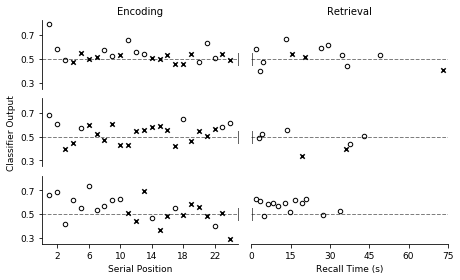

In [2]:
from plot_utils import plot_example_lists
lists = [['LTP366', 12, 24],
         ['LTP354', 3, 23],
         ['LTP207', 2, 21]]
fig, axes = plot_example_lists(lists, figsize=[6.5,4])

In [3]:
# fig.savefig('figures_final/examplelist.pdf')

In [2]:
def get_subject_ROC(subject, trainphase, testphase):
    
    f = 'scratch/mtpower/%s/%s_%s_%s_clsf_result.pkl'%(subject, subject, trainphase, testphase)
    resultpack = pkl.load(open(f,'rb'))
    y = resultpack['y']
    yhat = resultpack['yhat']
    roc, aucscore = compute_ROC_AUC(y, yhat, base=200)

    return roc, aucscore

def get_classifier_pval_1subj(subject, trainphase, testphase):
    aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(trainphase, testphase))
    aucscore = aucs[FR2_valid_subjects.tolist().index(subject)]
    f = 'scratch/mtpower/%s/%s_%s_%s_null_aucs.npy' % (subject, subject, trainphase, testphase)
    null_aucs = np.load(f)

    return np.sum(null_aucs>aucscore)/len(null_aucs)

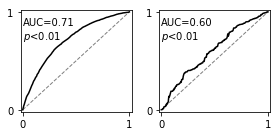

In [19]:
# Example ROC plot
subj_ind = 3
s = example_subjects[subj_ind-1]

fig, axes = plt.subplots(1,2,figsize=[4,2])

subj_ROC, subj_auc = get_subject_ROC(s, 'enc', 'enc')
plot_ROC(axes[0], roc=subj_ROC, text='AUC=%.2f\n'%subj_auc+r'$\it{p}$'+'<0.01')

subj_ROC, subj_auc = get_subject_ROC(s, 'retci', 'retci')
plot_ROC(axes[1], roc=subj_ROC, text='AUC=%.2f\n'%subj_auc+r'$\it{p}$'+'<0.01')

fig.tight_layout(h_pad=0)

In [20]:
# fig.savefig('figures_final/s%d_rocauc.pdf'%subj_ind)

In [23]:
def plot_auc_null_1subj(observed_auc, null_aucs):
    fig, ax = plt.subplots(1, 1, figsize=[2,1.2])
    ax.axvline(observed_auc, ymax=0.8, color='k')
    ax.hist(null_aucs, color='w', edgecolor='gray', bins=np.arange(0.35,0.75,0.01))
    ax.set_xlim([0.34, 0.75])
    ax.set_xticks([0.4,0.5,0.6,0.7])
    ax.set_ylim([0, 25])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    return fig, ax

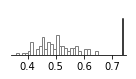

In [29]:
subj_ind = 1
s = example_subjects[subj_ind-1]
phase = 'retci'
observed_auc = get_subject_ROC(s, phase, phase)[1]
null_aucs = np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'%(s,s,phase,phase))
fig, ax = plot_auc_null_1subj(observed_auc, null_aucs)

# fig.savefig('figures_final/s%d_%s_aucnull.pdf'%(subj_ind, phase),
#              transparent=True, bbox_inches="tight")

#### group classification performance

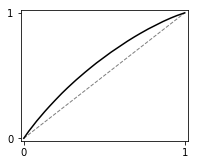

In [34]:
phase = 'enc'
roc_all = np.array([get_subject_ROC(s, phase, phase)[0] for s in FR2_valid_subjects])

fig, ax = plt.subplots(1, 1,figsize=[3, 2.4])
plot_ROC(ax, roc=roc_all.mean(0))

In [49]:
# fig.savefig('figures_final/clsf_%s.pdf'%phase)

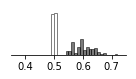

In [9]:
phase = 'enc'
observed_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(phase, phase))
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_%s_aucnull.pdf'%phase, transparent=True)

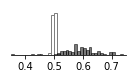

In [8]:
phase = 'retci'
observed_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(phase, phase))
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_%s_aucnull.pdf'%phase, transparent=True)

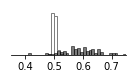

In [7]:
phase = 'retcp'
observed_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(phase, phase))
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_%s_aucnull.pdf'%phase, transparent=True)

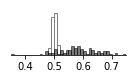

In [6]:
phase = 'retce'
observed_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(phase, phase))
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_%s_aucnull.pdf'%phase, transparent=True)

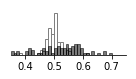

In [5]:
phase = 'retpe'
observed_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(phase, phase))
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_%s_aucnull.pdf'%phase, transparent=True)

#### activation figures

In [28]:
phase = 'enc'
sig_subjects = test_clsf_significance(phase, phase)[0] # subjects whose classifier is significant with p<0.05

result = []
for subject in sig_subjects:
    f = 'scratch/mtpower/%s/%s_%s_%s_clsf_result.pkl' % (subject, subject, phase, phase)
    values = pkl.load(open(f, 'rb'))['avgA']
#     values = split_ROIs(values, sys=get_eeg_sys(subject))
    result.append(values)

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.60   +-SE: 0.003678861857653041
    alpha=0.010: 	 88.00 significant
    alpha=0.050: 	 0.00 significant
    p<0.05:  88
    group binomial test:  p=0.00000000000, significant
    group t-test: t=27.540251, p=0.000000, significant


In [30]:
for x in result:
    print(np.min(x.values), np.max(x.values))

-2.693907071032072 1.5996063603984352
-2.1545203334622194 1.463313046862362
-3.080682039239396 1.1594691533922157
-4.192745902639105 0.23818613758175317
-4.830200857478499 0.4159595282058363
-0.3065089050497558 2.77566527012907
-2.370858954156797 0.8705165689128155
-0.81944293422621 0.8717301425283421
-1.8390589135291082 0.8126360964903512
-1.6521585028816208 0.8854007712002626
-1.1361414532852547 1.136259940509739
-1.7906557158636993 1.6225852650986554
-1.4883061639486004 0.9077161739412386
-1.972301816033002 1.0602509326138334
-0.1549192006880303 3.260619833885141
-2.155632718424806 2.07004984813728
-3.0377260620752167 0.6836415848232693
-2.3581232771831213 0.7909912509450099
-1.6990338650232941 0.9563136647349949
-1.3348705414861237 1.7335728429456905
-1.6340681608681134 1.6787339262262906
-1.2718001876322522 1.6938664011820017
-2.932537174885155 1.2307859517044983
-2.116307185281771 2.1471140310745884
-1.7985419547351196 0.2165026076350753
-1.7856950187558847 1.4018003595387358
-0.

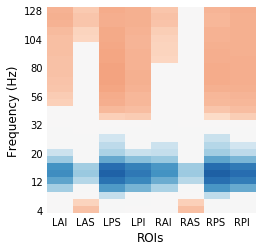

In [23]:
# encoding
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/clsf_atv_%s.pdf'%phase)

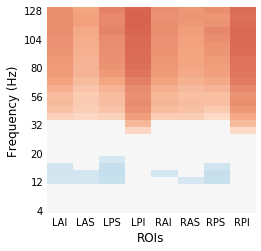

In [31]:
# retrieval
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/clsf_atv_%s.pdf'%phase)

In [40]:
phase = 'retce'
sig_subjects = test_clsf_significance(phase, phase)[0] # subjects whose classifier is significant with p<0.05

result = []
for subject in sig_subjects:
    f = 'scratch/mtpower/%s/%s_%s_%s_clsf_result.pkl' % (subject, subject, phase, phase)
    values = pkl.load(open(f, 'rb'))['avgA']
    values = split_ROIs(values, sys=get_eeg_sys(subject))
    result.append(values)

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retce    Test phase: retce
    Mean AUC: 0.58   +-SE: 0.007824967260542385
    alpha=0.010: 	 32.00 significant
    alpha=0.050: 	 18.00 significant
    p<0.05:  50
    group binomial test:  p=0.00000000000, significant
    group t-test: t=10.127454, p=0.000000, significant


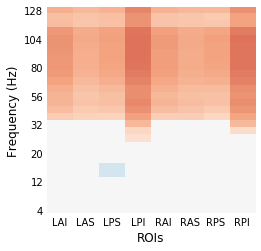

In [41]:
# other retrieval
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/clsf_atv_%s.pdf'%phase)